In [94]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import cmath
import scipy as sp
import sympy as sym
import imageio
import os

import warnings
warnings.filterwarnings('ignore')

from timeit import default_timer as timer
from scipy.linalg import eigh_tridiagonal
from scipy.linalg import eig
from scipy.linalg import eigh
from timeit import default_timer as timer

### Methods (functions for now) to create/build/calculate matrices, and finally expected values (at least for time independent case for now).

In [2]:
def H1dlight(N,tj,epsilonj,lambdaj,periodic = False):
    '''
    Define matrix Hamiltonian
    '''
    A = np.zeros((N,N),dtype=complex)
    for i in range(N-1):
        A[i][i] = epsilonj[0][i]
        A[i][i+1] = -tj[0][i]*np.exp(1j*lambdaj[0][i])
        A[i+1][i] = -tj[0][i]*np.exp(-1j*lambdaj[0][i])
    #for the last e-
    A[N-1,N-1] = epsilonj[0][N-1]
    if periodic:
        A[0][N-1] += -tj[0][N-1]*np.exp(-1j*lambdaj[0][N-1]) #in order to fix the two particles problem
        A[N-1][0] +=  -tj[0][N-1]*np.exp(1j*lambdaj[0][N-1])
    #print(A)
    return A


def total_energy(N,tj,epsilonj,lambdaj,periodicity):
    Hhamilton = H1dlight(N,tj,epsilonj,lambdaj,periodic = periodicity)
    eigen_comp = eigh(Hhamilton, eigvals_only = False)
    try:
        newN = int(n)
        total_E = np.sum(eigen_comp[0][0:newN]) #How could we know wich energies correspond to 
        total_eigen = eigen_comp[1][0:newN]
    except NameError:
        newN = int(n)
        total_E = np.sum(eigen_comp[0][0:newN])
        total_eigen = eigen_comp[1][0:newN]
    return total_E,total_eigen    


def expectH(H4o,for3parti):
    N = len(for3parti[0])
    Hexpectedv = 0
    for i in range(N):
        for j in range(N):
            Hexpectedv = for3parti[i][j]*H4o[i][j] + Hexpectedv
    return Hexpectedv


def expectN(for3parti):
    N = len(for3parti[0])
    Nexpectedv = 0
    for i in range(N):
        Nexpectedv = for3parti[i][i] + Nexpectedv
    return Nexpectedv


def expectK(H4o,for3parti):
    N = len(for3parti[0])
    Kexpectedv = 0
    for i in range(N):
        for j in range(N):
            if j>i: Kexpectedv = for3parti[i][j]*H4o[i][j] + Kexpectedv + for3parti[j][i]*H4o[j][i]
    return Kexpectedv


def readpart(gs):
    n = 0
    for i in gs:
        n += i
    return n



def occupationplotj(Hamilton, eigendiag,n):
    N = len(eigendiag[0])
    occup = np.zeros((2,N))
    corrm = correlationeigh(Hamilton,eigendiag,n)
    for i in range(N):
        occup[0][i] = float(i)
        occup[1][i] = float(corrm[i][i])
    print(occup)
    occplot(occup, labelo = '$\hat{n}_{i}$')
    pass




### Plotting auxiliary functions:

In [84]:
def evstplot(arr,labelo ='$E_{0}$'):
    plt.plot(arr[0],arr[1], label=labelo,color='r')

    plt.title('$E_{0}$ vs t')
    plt.legend()
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('$E_{0}$')
    return plt.show()


def occplot(arr,labelo ='$E_{0}$'):
    plt.plot(arr[0],arr[1],'o', label=labelo,color='k')

    plt.title(labelo + ' vs i')
    plt.legend()
    plt.grid()
    plt.xlabel('i')
    plt.ylabel(labelo)
    plt.ylim([-0.1,1.1])
    return plt.show()

def occplotvoid(arr,labelo ='$E_{0}$'):
    plt.plot(arr[0],arr[1],'o', label=labelo,color='k')

    plt.title(labelo + ' vs i')
    plt.legend()
    plt.grid()
    plt.xlabel('i')
    plt.ylabel(labelo)
    plt.ylim([-0.1,1.1])
    #return plt.show()


def fourier(patron):
    FT1=np.fft.fft2(patron)
    FT2=np.abs(np.fft.fftshift(FT1))
    FT=FT2/FT2.max()
    plt.imshow((FT),origin='lower')
    plt.colorbar()
    plt.ylabel(r'$t$', fontsize = 13)
    plt.xlabel(r'$k_x$', fontsize = 13)
    
    #plt.savefig('imag1com.png')
    plt.show()
    
    
def occupationplotj3eh(Hamilton, eigendiag,t):
    N = len(eigendiag[0])
    occup = np.zeros((2,N))
    corrm = correlationt3eh(Hamilton,eigendiag,t)
    for i in range(N):
        occup[0][i] = float(i)
        occup[1][i] = float(corrm[i][i])
    print(occup)
    occplot(occup, labelo = '$\hat{n}_{i}$')
    pass

def genoccupationplot(correlation):
    N = len(correlation[0])
    occup = np.zeros((2,N))
    for i in range(N):
        occup[0][i] = float(i)
        occup[1][i] = float(correlation[i][i])
    #print(occup)
    occplot(occup, labelo = '$\hat{n}_{i}$')

def genoccupationplotvoid(correlation):
    N = len(correlation[0])
    occup = np.zeros((2,N))
    for i in range(N):
        occup[0][i] = float(i)
        occup[1][i] = float(correlation[i][i])
    #print(occup)
    occplotvoid(occup, labelo = '$\hat{n}_{i}$')

    

### Some auxiliary functions that I used to run test (speacially to verify diagonalization):

In [10]:
def testingeigenvalueseq(H4o,quietatos):
    for i in range(N):
        print(quietatos[0][i])
        print(quietatos[1].dot(quietatos[1][i])) #Makes sense (giving eigenenergy only with eig, not eigh)
        
def testingbasechange(H4o,quietato):
    firstproduct = np.transpose(quietato[1]).dot(H4o)
    secondproduct = firstproduct.dot(quietato[1])
    #print(secondproduct)
    return secondproduct
    #print(np.transpose(quietato[1]).dot(quietato[1]))
    for i in range(N):
        #print(secondproduct.dot(quietato[1][i]))
        pass


### Methods to calculate different correlation matrices (Couldn't build something generic, although the method for case TWO actually works perfectly in the static scenario). (FOURTH case method should also be able to reproduce every system as long as the H is time independent and the state has defined occupation in real space).

In [11]:
## Trying to build correlation matrix

def correlation(Hamilton, Veigen,k):
    '''
    Method designed for using eig as diagonalization rutine,
    This is clearly more complex than using eigh rutine
    because the eigvalues are not arranged from lower to higher.
    '''
    N = len(Veigen[0])
    correlation = np.zeros((N,N),dtype=complex)
    #firstproduct = np.transpose(Veigen[1]).dot(Hamilton)
    #diagonal = firstproduct.dot(Veigen[1])
    mineigen = np.real(np.min(Veigen[0]))
    indexmin = list()
    indexmin_0 = np.where(Veigen[0] == mineigen)[0] 
    [indexmin.append(i) for i in indexmin_0]
    print(mineigen,indexmin)
    new_Veigen = np.delete(Veigen[0],indexmin_0)
    if len(indexmin) < k:
        print("siguiendo")
        for i in range(k-(len(indexmin))):
            if len(indexmin) < k:
                print(indexmin)
                i = i +1
                new_Veigen = np.delete(Veigen[0],indexmin)
                print("continuando ", new_Veigen)
                mineigen = np.min(new_Veigen)
                #print(mineigen)
                indexmin_0 = np.where(Veigen[0] == mineigen)[0] 
                [indexmin.append(j) for j in indexmin_0]
                print(i,indexmin)
                i = i +1#+ ()
    for kmin in indexmin:
        for i in range(N):
            for j in range(N):
                ##print(correlation)
                correlation[i][j] = Veigen[1][j][kmin] *(np.transpose(np.conjugate(Veigen[1])))[kmin][i] + correlation[i][j]
                ##print(correlation)
    print(indexmin)
    return correlation


def correlationeigh(Hamilton, Veigen,k):
    '''
    Method designed to be used with eigh rutine, wich receives the real space Hamiltonian,
    The Veigen with eigenvalues and eigenvector arranged from lower to higher,
    and k the number of electrons in the chain.
    '''
    N = len(Veigen[0])
    correlation = np.zeros((N,N),dtype=complex)
    #firstproduct = np.transpose(Veigen[1]).dot(Hamilton)
    #diagonal = firstproduct.dot(Veigen[1])
    for kmin in range(k):
        for i in range(N):
            for j in range(N):
                ##print(correlation)
                correlation[i][j] = Veigen[1][j][kmin] *(np.transpose(np.conjugate(Veigen[1])))[kmin][i] + correlation[i][j]
                ##print(correlation)
    #print(indexmin)
    return correlation
def sumaexp(Veigen,tiempo):
    suma = 0
    for i in Veigen[0]:
        suma += np.exp(1j*2*i*tiempo)
    return suma
    

    
def correlationt3eh(Hamiltonian,Veigen,t):
    N = len(Veigen[0])
    correlation = np.zeros((N,N),dtype=complex)
    identity = np.eye((N),dtype=complex)
    for i in range(N):
        for j in range(N):
            correlation[i][j] = 0.5*identity[i][j]
            for k in range(N):
                correlation[i][j] -= 0.5*(-1)**j* Veigen[1][j][k] *(np.transpose(np.conjugate(Veigen[1])))[k][i]*np.exp(1j*2*Veigen[0][k]*t)
    return correlation    
    

from scipy.linalg import expm
def correlationt4rspace(Hamiltonian,state,t):
    N = len(state)
    correlation = np.zeros((N,N),dtype=complex)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                if state[k]==1:
                    correlation[i][j] += expm(-1j*Hamiltonian*t)[j][k]*expm(1j*Hamiltonian*t)[k][i]
    return correlation


    
def correlationeighq(Hamilton, Veigen,k,tiempo):
    '''
    Method Originally thought to be used for Quenching.
    IT DIDN'T WORK LAST TIME, but it intended to change the eigenvalues over time.
    Gotta check mutability because something weird was going on.
    '''
    N = len(Veigen[0])
    correlation = np.zeros((N,N),dtype=complex)
    #firstproduct = np.transpose(Veigen[1]).dot(Hamilton)
    #diagonal = firstproduct.dot(Veigen[1])
    for kmin in range(k):
        for i in range(N):
            for j in range(N):
                if i ==j:
                    
                    correlation[i][i] = 0.5 - (0.5/N)*(-1)**(i)*sumaexp(Veigen,tiempo)
                else:
                    ##print(correlation)
                    correlation[i][j] += -0.5*(np.transpose(np.conjugate(Veigen[1])))[int(np.abs(kmin-N/2))][i]*Veigen[1][j][kmin] *np.exp(np.exp(1j*2*Veigen[0][kmin]*tiempo))
                ##print(correlation)
    #print(indexmin)
    return correlation


def correlationTBtev(Hamilton, Veigen,k):
    '''
    Method yet to be build intended to be used for time evolution with an dependent time Hamiltonians (probably).
    '''
    N = len(Veigen[0])
    correlation = np.zeros((N,N),dtype=complex)
    #firstproduct = np.transpose(Veigen[1]).dot(Hamilton)
    #diagonal = firstproduct.dot(Veigen[1])
    for kmin in range(k):
        for i in range(N):
            for j in range(N):
                ##print(correlation)
                correlation[i][j] = Veigen[1][j][kmin] *(np.transpose(np.conjugate(Veigen[1])))[kmin][i] + correlation[i][j]
                ##print(correlation)
    #print(indexmin)
    return correlation    

[[ 0.+0.j -1.+0.j  0.+0.j -1.+0.j]
 [-1.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j -1.+0.j]
 [-1.+0.j  0.+0.j -1.+0.j  0.+0.j]] 

[[ 0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j]
 [ 0.25+0.j  0.75+0.j  0.25+0.j -0.25+0.j]
 [ 0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j]
 [ 0.25+0.j -0.25+0.j  0.25+0.j  0.75+0.j]] 

[[-5.55111512e-17+0.j -2.77555756e-17+0.j  1.11022302e-16+0.j
  -1.38777878e-17+0.j]
 [ 2.77555756e-17+0.j  1.00000000e+00+0.j -8.32667268e-17+0.j
  -1.24900090e-16+0.j]
 [ 1.11022302e-16+0.j  8.32667268e-17+0.j -2.77555756e-17+0.j
   8.32667268e-17+0.j]
 [ 1.38777878e-17+0.j -1.24900090e-16+0.j -8.32667268e-17+0.j
   1.00000000e+00+0.j]] 

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]] 

(array([-2.00000000e+00,  0.00000000e+00,  2.66453526e-15,  2.00000000e+00]), array([[-5.00000000e-01-0.j,  0.00000000e+00+0.j, -7.07106781e-01-0.j,
         5.00000000e-01+0.j],
       [-5.00000000e-01+0.j, -7.0

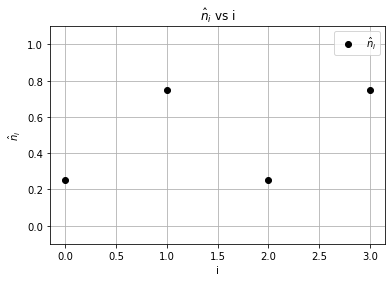

[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00  3.00000000e+00]
 [-5.55111512e-17  1.00000000e+00 -2.77555756e-17  1.00000000e+00]]


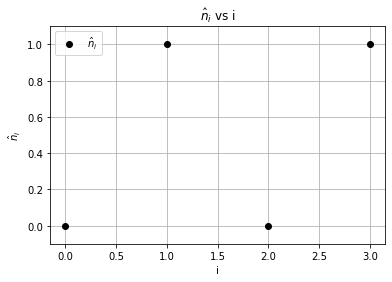

[[0.   1.   2.   3.  ]
 [0.25 0.75 0.25 0.75]]


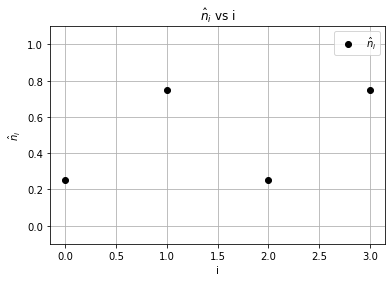

[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00  3.00000000e+00]
 [-5.55111512e-17  1.00000000e+00 -2.77555756e-17  1.00000000e+00]]


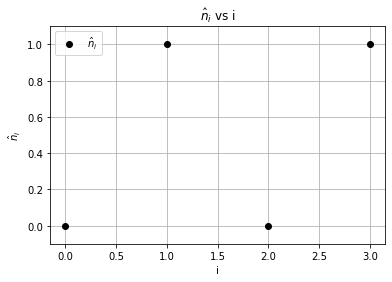

[[0. 1. 2. 3.]
 [0. 1. 0. 1.]]


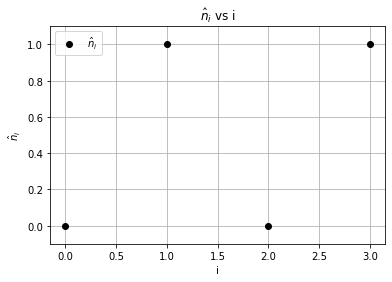

In [72]:
BC = True
eps = 0
t = 1
ground = (0,1,0,1)
#ground = list()
#for i in range(1):
#    ground.append(1)
#for i in range(2):
#    ground.append(0)
n = readpart(ground)
N = len(ground)
a0 = 0.303
epsilonl = np.ones((1,N))*eps
tl = np.ones((1,N))*t
#epsilonl[0][int(10)] = -1
#tl[0][0] = 1
tiempo_min = 0
tiempo_max = 8*np.pi
tiempo = np.linspace(tiempo_min,tiempo_max,100)
Evstlin = np.zeros((2,len(tiempo)))
ExpH = np.zeros((2,len(tiempo)))
ExpK = np.zeros((2,len(tiempo)))
Euwu = np.zeros((2,len(tiempo)))
puestot = int(len(tiempo)/3)
for i in range(len(tiempo)):
    E_0 = -0.5* a0 * tiempo[i]
    phasesl = np.ones((1,N),dtype=complex)*0.0#E_0#*np.complex(0+1j) #*np.log(2)
    if i ==0:
        vectorpulselinear = total_energy(N,tl,epsilonl,phasesl,periodicity = BC)[1]
        H0_lightlinear = H1dlight(N,tl,epsilonl,phasesl,periodic = BC)
        #vectorpulselinearq = total_energy(N,tl,epsilonl,phasesl*-0.5* a0*tiempo[puestot],n,periodicity = BC)[1]
        H0_lightlinearq = H1dlight(N,tl,epsilonl,phasesl*-0.5* a0*tiempo[puestot],periodic = BC)

    Hlight = H1dlight(N,tl,epsilonl,phasesl,periodic = BC)
    #eigenvalues
    eigenergieslp = eigh(H0_lightlinear,eigvals_only = False)
    eigenergieslpn = eigh(Hlight,eigvals_only = False)
    #anallytical
    eigenergieslp = eigenergieslpn
    Euwu[0][i] = E_0
    Evstlin[0][i],ExpH[0][i],ExpK[0][i]  = tiempo[i],tiempo[i],tiempo[i]
    Evstlin[1][i] = total_energy(N,tl,epsilonl,phasesl,periodicity = BC)[0]
    #eigenergieslpt = tev4Hindep(eigenergieslp,i)
    for3parti = correlationeighq(H0_lightlinear,eigenergieslp,n,t)
    #for3parti = correlationeigh(H0_lightlinear,eigenergieslp,n)
    #print(for3parti)#, eigenergieslp,eigenergieslpt)
    if i>0:
        ExpH[1][i] = expectH(H0_lightlinearq,for3parti)
        ExpK[1][i] = expectK(H0_lightlinearq,for3parti)
    else:
        for3parti = correlationeigh(H0_lightlinear,eigenergieslp,n)
        ExpH[1][i] = expectH(H0_lightlinear,for3parti)
        ExpK[1][i] = expectK(H0_lightlinear,for3parti)
    
    #print(eigenergieslp,Hlight)
    
print(H0_lightlinear, '\n')
print(correlationeigh(H0_lightlinear,eigenergieslp,n),'\n')
print(correlationt3eh(H0_lightlinear,eigenergieslp,0),'\n')
print(correlationt4rspace(H0_lightlinear,ground,0),'\n')
print(eigenergieslp)
aloz = correlationeigh(H0_lightlinear,eigenergieslp,n)
aloz3 = correlationt3eh(H0_lightlinear,eigenergieslp,0)
aloz4 = correlationt4rspace(H0_lightlinear,ground,0)

##   print(Evstlin[1][i])
#print(Evstlin[1][0],vectorpulselinear, H0_lightlinear)
##evstplot(Evstlin)
#evstplot(ExpH, labelo = '$\hat{H}$')
##evstplot(ExpK, labelo = '$\hat{K}$')
#occupationplotj(H0_lightlinear,eigenergieslp,n)
#occupationplotj3eh(H0_lightlinear,eigenergieslp,0)
genoccupationplot(aloz)
genoccupationplot(aloz3)
genoccupationplot(aloz4)


[1. 1. 0. 0.]


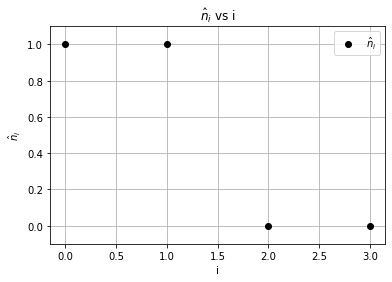

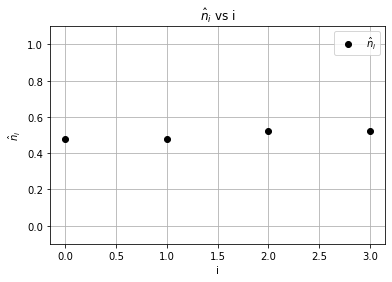

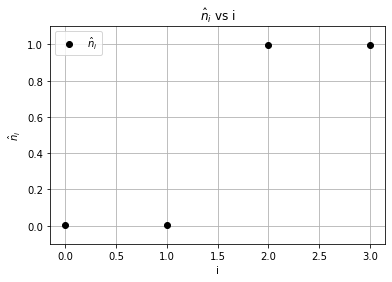

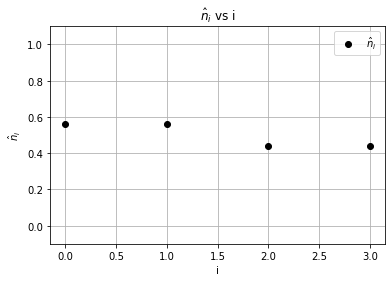

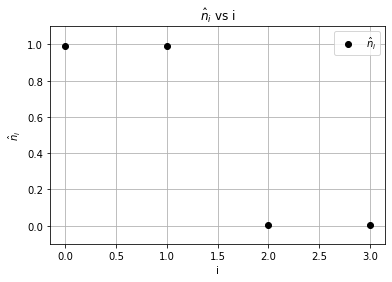

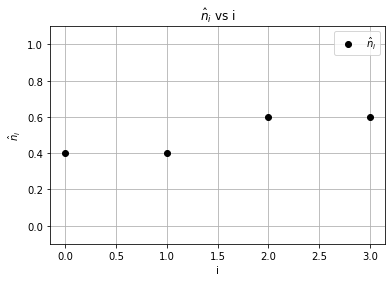

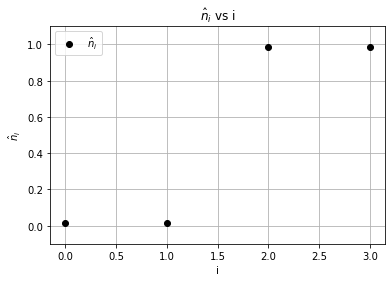

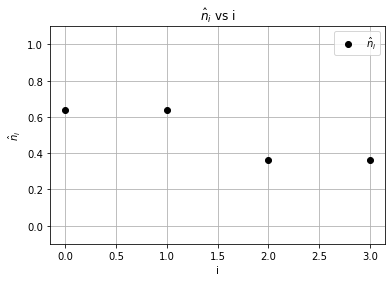

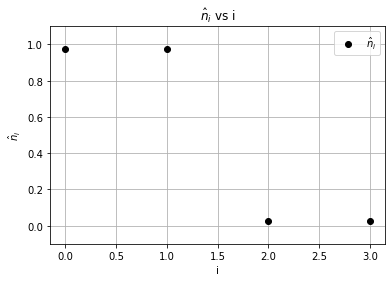

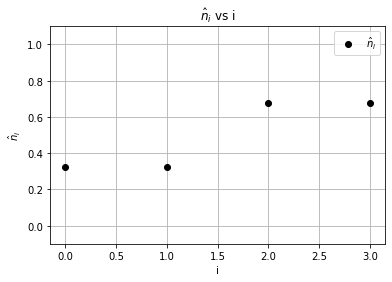

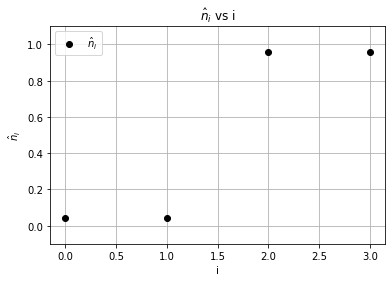

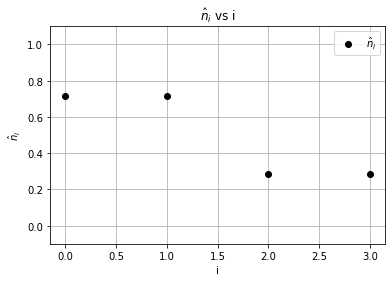

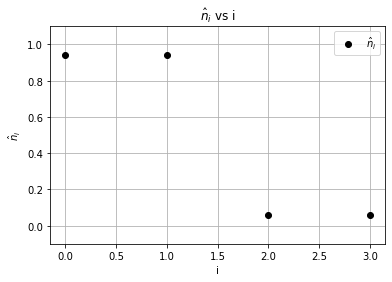

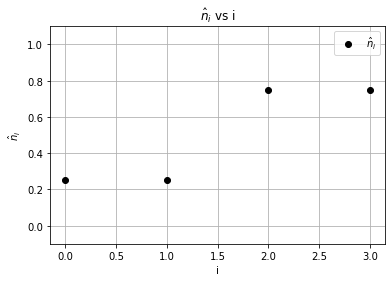

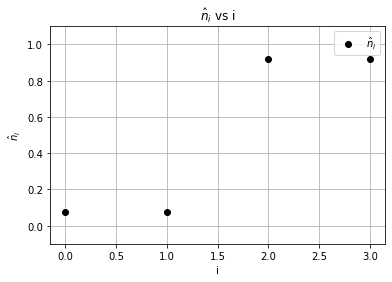

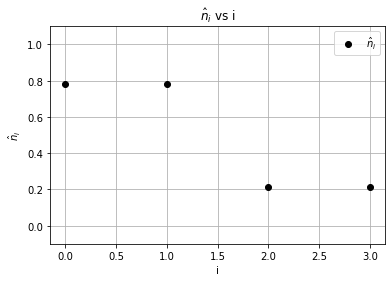

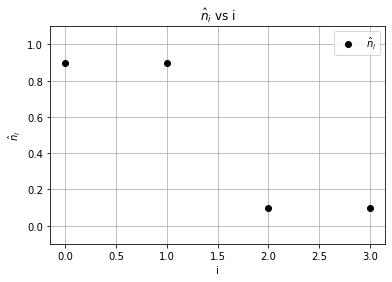

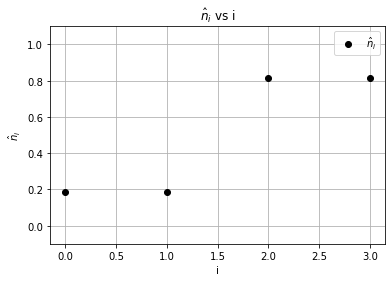

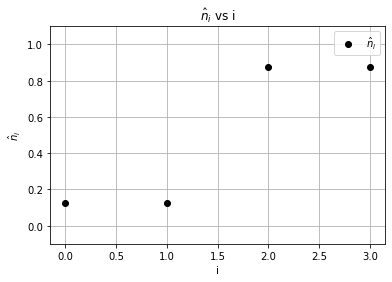

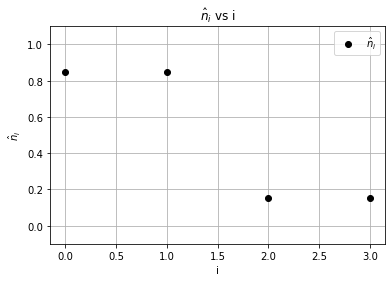

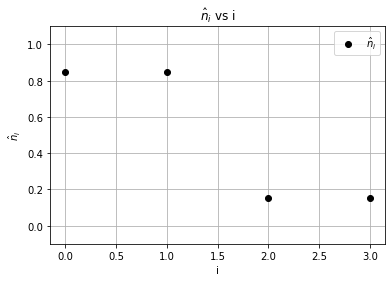

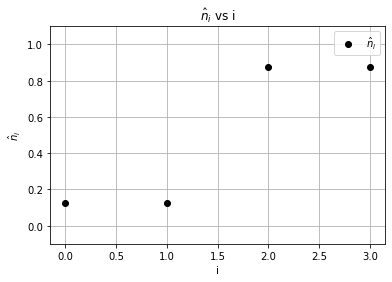

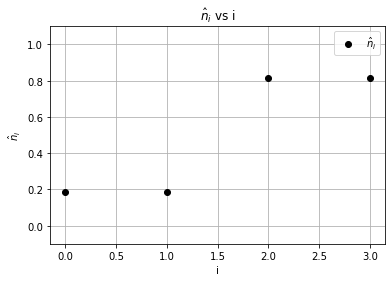

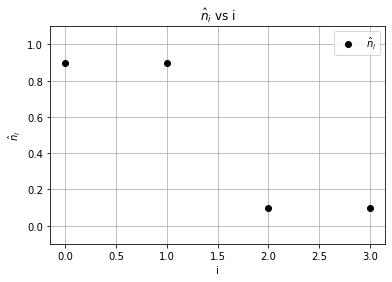

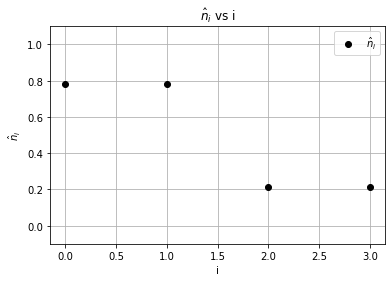

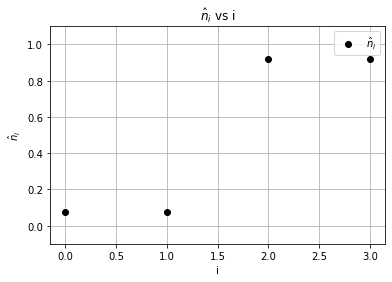

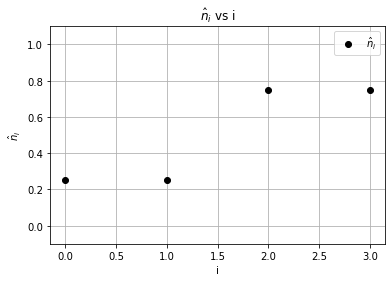

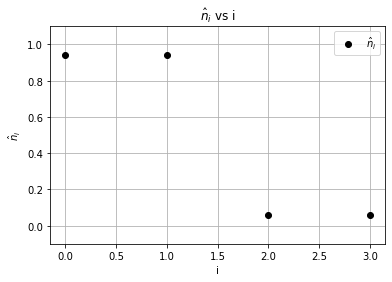

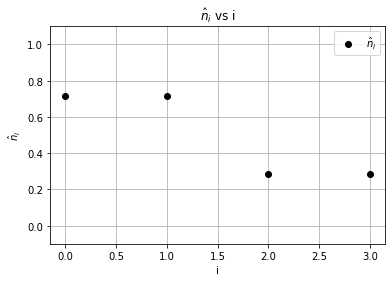

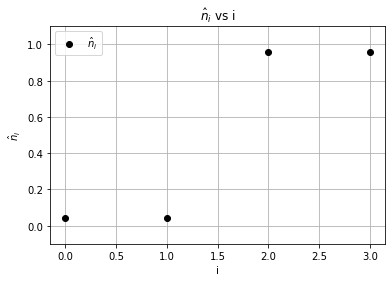

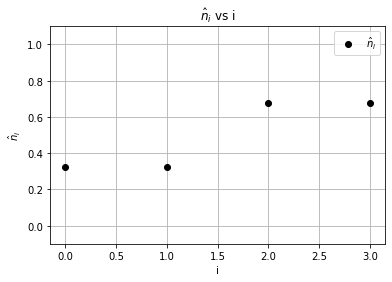

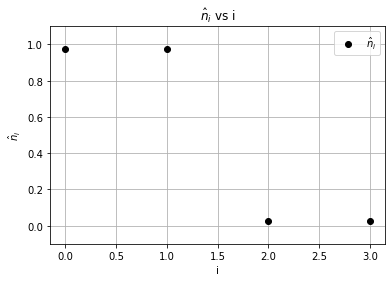

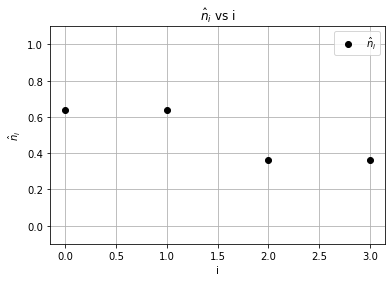

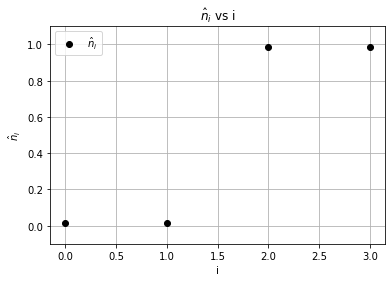

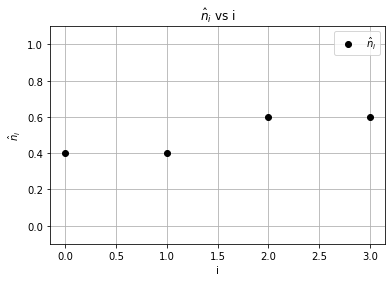

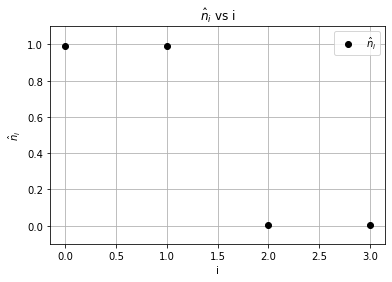

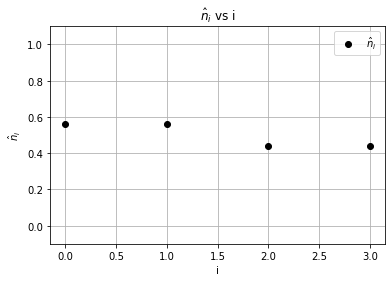

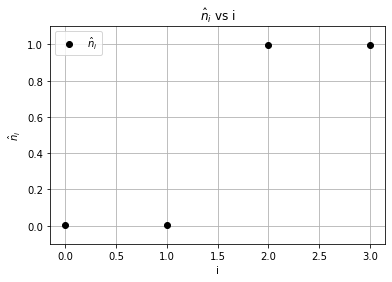

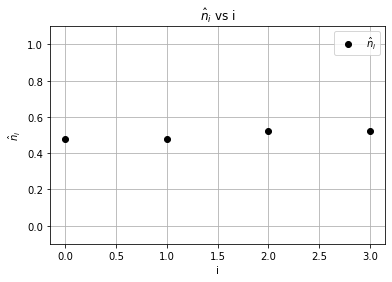

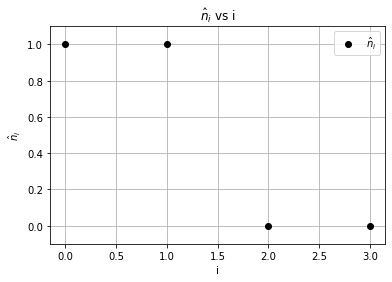

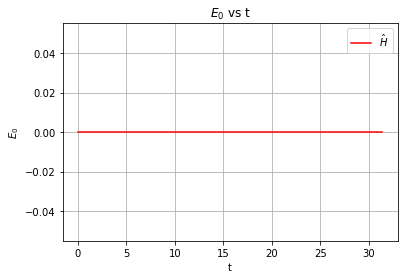

In [112]:
def tevhindep(choose,tmin,tmax,Hamiltonian,Veigen,state,n):
    time = np.linspace(tmin,tmax,40)
    ExpH = np.zeros((2,len(time)))
    ExpH[0] = time 
    for i in range(len(time)):
        correlation = creatcorr(choose,Hamiltonian, Veigen,state,time[i],n)
        #print(correlation)
        ExpH[1][i] = expectH(Hamiltonian,correlation)
        genoccupationplot(correlation)
    return ExpH
          
BC, eps, hopp, L, num = True, 0, 1, 4, 2
tmin,tmax = 0,10*np.pi
ground = phi0rspace('wall',L, n= 1)
n = int(readpart(ground))
hopping = np.ones((1,L))*hopp
epsilon = np.ones((1,L))*eps
##epsilon[0][num] = -100
##hopping[0][num] = 1
phases = np.zeros((1,L))*0

H0 = H1dlight(L,hopping,epsilon,phases,periodic = BC)
eigvv = eigh(H0,eigvals_only = False)

expected = tevhindep('4rspace',tmin,tmax,H0,eigvv,ground,n)

evstplot(expected, labelo = '$\hat{H}$')


### Possible utilities and stufff

In [111]:
def phi0rspace(parameter,N, n = 0):
    switch ={
        'eh' : phi0eh(N),
        'wall': phi0wall(N),
        'gs': phi0gs(N,n)
    }
    phi0 = switch.get(parameter)
    print(phi0)
    return phi0

def creatcorr(parameter,Hamiltonian, Veigen, state,t, n):
    switch ={
        '2static' : correlationeigh(Hamiltonian,Veigen,n),
        '3eh': correlationt3eh(Hamiltonian,Veigen,t),
        '4rspace': correlationt4rspace(Hamiltonian, state, t)
    }
    return switch.get(parameter)

def phi0gs(N,n):
    phi = list()
    for i in range(n):
        phi.append(1)
    for i in range(N-n):
        phi.append(0)
    #print(phi)
    return phi

def phi0eh(N):
    phi = list()
    for i in range(int(N/2)):
        phi.append(0)
        phi.append(1)
    return phi

def phi0wall(N):
    if N%2 ==1:
        A=N-1
    else: A=N
    phi = np.ones(int(A/2))
    phi = np.concatenate((phi,np.zeros(int(N-A/2))))
    return phi        

In [47]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Trying to make a gif to see time evolution for $\hat{n}_i$ vs i

[0, 0, 0, 0]


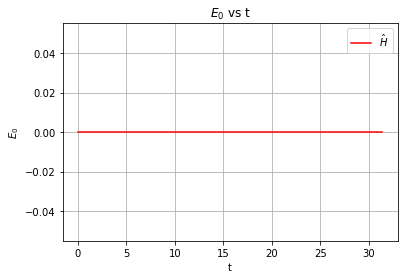

In [107]:
def tevhindepgif(choose,tmin,tmax,Hamiltonian,Veigen,state,n):
    time = np.linspace(tmin,tmax,40)
    filenames = [] #For images
    ExpH = np.zeros((2,len(time)))
    ExpH[0] = time 
    for i in range(len(time)):
        correlation = creatcorr(choose,Hamiltonian, Veigen,state,time[i],n)
        #print(correlation)
        ExpH[1][i] = expectH(Hamiltonian,correlation)
        genoccupationplotvoid(correlation)
        filename = f'{i}.jpg'
        filenames.append(filename)
        plt.savefig(filename, bbox_inches = 'tight')
        plt.close()
        
    with imageio.get_writer('mygif.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)   
    for filename in set(filenames):
        os.remove(filename)
    
    return ExpH


BC, eps, hopp, L = True, 0, 1, 4
tmin,tmax = 0,10*np.pi
ground = phi0rspace('eh',L)
n = int(readpart(ground))
hopping = np.ones((1,L))*hopp
epsilon = np.ones((1,L))*eps
##epsilon[0][num] = -100
##hopping[0][num] = 1
phases = np.zeros((1,L))*0

H0 = H1dlight(L,hopping,epsilon,phases,periodic = BC)
eigvv = eigh(H0,eigvals_only = False)

expected = tevhindepgif('3eh',tmin,tmax,H0,eigvv,ground,n)

evstplot(expected, labelo = '$\hat{H}$')
